# Factorización de Matrices y Máquinas

## Integrantes

- Sebastián Gacitúa
- Bastián Guzmán
- Jose Zamora
- Leandro Aroca
- Matthias Clein

En este laboratorio deberá ajustar un modelo de factorización de matrices y uno de factorización de máquina para predecir el contenido que un usuario “cliquearía” en una página web. La información necesaria se encuentra en el siguiente vínculo: https://www.kaggle.com/c/outbrain-click-prediction.

Se le evaluará por:
    
*  2 puntos: Presentación del problema y solución (haga un documento para entregar, que quede ordenado, introducción, cuerpo y conclusiones.)
*  1 punto: Limpieza y creacion de features.
*  2 puntos: Ajuste de modelo.
*  1 puntos: Predicción de 5 usuarios al azar 5 más probables. Realice una muestra en testeo y muestre los resultados que esperaba obtener y los que su modelo entregó.

## Descrpción General del Dataset
### Outbrain Click Prediction 


Internet es un estimulante tesoro de posibilidades. Todos los días nos topamos con noticias relevantes para nuestras comunidades o experimentamos la casualidad de encontrar un artículo que cubre nuestro próximo destino de viaje. Outbrain, la plataforma de descubrimiento de contenido líder en la web, ofrece estos momentos mientras navegamos por nuestros sitios favoritos.

Actualmente, Outbrain combina contenido relevante con lectores curiosos en alrededor de 250 mil millones de recomendaciones personalizadas cada mes en muchos miles de sitios. En esta competencia, los Kagglers tienen el desafío de predecir en qué piezas de contenido es probable que haga clic su base global de usuarios. Mejorar el algoritmo de recomendación de Outbrain significará que más usuarios descubrirán historias que satisfagan sus gustos individuales.



El conjunto de datos para este desafío contiene una muestra de las visitas a la página y los clics de los usuarios, tal como se observó en varios sitios de editores en los Estados Unidos entre el 14 y el 28 de junio de 2016. Cada página visitada o recomendación en la que se ha hecho clic se acompaña además de algunos atributos semánticos de esos documentos. Para obtener detalles completos, consulte las especificaciones de datos a continuación.

El conjunto de datos contiene numerosos conjuntos de recomendaciones de contenido que se sirven a un usuario específico en un contexto específico. Cada contexto (es decir, un conjunto de recomendaciones) recibe un **display_id**. En cada uno de estos conjuntos, el usuario ha hecho clic en al menos una recomendación. Las identidades de las recomendaciones en las que se hizo clic en el conjunto de prueba no se revelan. Su tarea es clasificar las recomendaciones en cada grupo disminuyendo la probabilidad prevista de que se haga clic en ellos.

Como advertencia, este es un conjunto de datos relacional muy grande. Si bien la mayoría de las tablas son lo suficientemente pequeñas como para caber en la memoria, el registro de vistas de página (**page_views.csv**) tiene más de 2 mil millones de filas y 100 GB sin comprimir. También hemos subido una versión de muestra de este archivo con las primeras 10 000 000 filas.

### Data Fields

Cada usuario en el conjunto de datos está representado por una identificación única (**uuid**). Una persona puede ver un documento (**document_id**), que es simplemente una página web con contenido (por ejemplo, un artículo de noticias). En cada documento, se muestra un conjunto de anuncios (**ad_id**). Cada anuncio pertenece a una campaña (**campaign_id**) ejecutada por un anunciante (**advertiser_id**). También se le proporcionan metadatos sobre el documento, como qué entidades se mencionan, una taxonomía de categorías, los temas mencionados y el editor.

### File Descriptions

**page_views.csv:** es un registro de usuarios que visitan documentos. Para ahorrar espacio en disco, las marcas de tiempo en todo el conjunto de datos son relativas a la primera vez en el conjunto de datos. Si desea recuperar la época actual de la visita, agregue 1465876799998 a la marca de tiempo.

*  **uuid:** Identificación única de usuario
*  **document_id:** Documento o página web con contenido (ejemplo: Noticias)
*  **timestamp (ms since 1970-01-01 - 1465876799998)**
*  **platform (desktop = 1, mobile = 2, tablet =3)**
*  **geo_location (country>state>DMA)**
*  **traffic_source (internal = 1, search = 2, social = 3)**

**clicks_train.csv:** es el conjunto de entrenamiento, que muestra en cuál de un conjunto de anuncios se hizo clic.

*  **display_id:** conjunto de recomendaciones
*  **ad_id:** conjunto de anuncios
*  **clicked (1 if clicked, 0 otherwise):**

**clicks_test.csv:** es lo mismo que **clicks_train.csv**, excepto que no tiene el anuncio en el que se hizo clic. Este es el archivo que debe usar para predecir. Cada display_id tiene solo un anuncio en el que se hizo clic. Tenga en cuenta que el conjunto de prueba contiene display_ids de todo el período de tiempo del conjunto de datos. Además, el muestreo público/privado para la competencia es uniformemente aleatorio, no basado en el tiempo. Estas elecciones de muestreo fueron intencionales, a pesar de la posibilidad de que los participantes puedan mirar hacia adelante en el tiempo.

**sample_submission.csv:** muestra el formato de envío correcto.

**events.csv:** proporciona información sobre el contexto **display_id**. Cubre tanto el set entrenamiento como de test.

*  **display_id**
*  **uuid**
*  **document_id**
*  **timestamp**
*  **platform**
*  **geo_location**

**promoted_content.csv:** proporciona detalles sobre los anuncios.

*  **ad_id**
*  **document_id**
*  **campaign_id**
*  **advertiser_id**

**documents_meta.csv:** proporciona detalles sobre los documentos.

*  **document_id**
*  **source_id (the part of the site on which the document is displayed, e.g. edition.cnn.com)**
*  **publisher_id**
*  **publish_time**

**documents_topics.csv**, **documents_entities.csv** y **documents_categories.csv** proporcionan información sobre el contenido de un documento, así como la confianza de Outbrain en cada relación respectiva. Por ejemplo, **entity_id** puede representar a una persona, organización o ubicación. Las filas en **documents_entities.csv** dan la confianza de que se hizo referencia a la entidad dada en el documento.

![page_view](../img/page_view.png)

![modelo_er](../img/diagrama_er.png)

## Librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, add, Activation, dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2 as l2_reg
import itertools
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

2022-12-26 12:01:21.218796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Factorización de Matrices

Se carga el dataset de *clicks para entrenamiento*, el cual contiene un *display_id*, *ad_id* y *clicked* que es la variable que se quiere predecir.

In [2]:
dataset = pd.read_csv('../data/clicks_train.csv', sep = ',', nrows=10000)
dataset.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


Se crean columnas nuevas para respaldar los valores originales de los *id's*. 

In [3]:
dataset["display_id_original"] = dataset["display_id"]
dataset["ad_id_original" ] = dataset["ad_id"]

Convertimos a valores numéricos las variables categóricas (*id's*).

In [4]:
dataset.display_id = dataset.display_id.astype('category').cat.codes.values #Convierte en valores numéricos categóricos
dataset.ad_id = dataset.ad_id.astype('category').cat.codes.values #Convierte en valores numéricos categóricos

In [5]:
dataset["ad_id"].value_counts()

2646    50
2113    50
4225    44
1134    43
2778    37
        ..
756      1
2705     1
3162     1
3615     1
2577     1
Name: ad_id, Length: 4319, dtype: int64

In [6]:
dataset["display_id"].value_counts()

918     12
543     12
914     10
1361    10
1701    10
        ..
599      2
1839     2
397      2
398      2
1007     2
Name: display_id, Length: 1959, dtype: int64

In [7]:
dataset.describe()

,display_id,ad_id,clicked,display_id_original,ad_id_original
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,986.437100,2207.364200,0.195900,987.437100,156850.550300
std,566.631537,1189.417955,0.396912,566.631537,83494.478172
min,0.000000,0.000000,0.000000,1.000000,1174.000000
25%,494.750000,1222.750000,0.000000,495.750000,92111.500000
50%,995.000000,2220.000000,0.000000,996.000000,153204.000000
75%,1478.250000,3198.000000,0.000000,1479.250000,211592.000000
max,1958.000000,4318.000000,1.000000,1959.000000,348149.000000


Separamos el dataset en dos conjuntos: *entrenamiento (train)* y *prueba (test)*.

In [8]:
train, test = train_test_split(dataset, test_size=0.2)

Se define la cantidad de *factores latentes*.

In [9]:
n_displays, n_ads = len(dataset.display_id.unique()), len(dataset.ad_id.unique())
n_latent_factors = 20

Verificamos la cantidad de displays y ads presentes en el dataset.

In [10]:
print("displays",n_displays)
print("ads",n_ads)

displays 1959
ads 4319


Construimos un modelo considerando una matriz de *Items* y otra de *Usuarios*, el producto punto de ambas generará el modelo final.

In [11]:
ad_input = keras.layers.Input(shape=[1],name='Item')
ad_embedding = keras.layers.Embedding(n_ads + 1, n_latent_factors, name='ad-Embedding')(ad_input)
ad_vec = keras.layers.Flatten(name='Flatten-ad')(ad_embedding)

display_input = keras.layers.Input(shape=[1],name='User')
display_embedding = keras.layers.Embedding(n_displays + 1, n_latent_factors,name='display-Embedding')(display_input)
display_vec = keras.layers.Flatten(name='Flatten-display')(display_embedding)

prod = keras.layers.dot([ad_vec, display_vec], axes=1,name='DotProduct')
model = keras.Model([display_input, ad_input], prod)

2022-12-26 12:01:47.775279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compilamos el modelo utilizando un optimizador de tipo Adam, una función de pérdida *MSE* (porque estamos haciendo una regresión), y definiremos como métricas de evaluación el *mae* y el *mse*. 

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

El resumen del modelo nos indica que tiene 125.600 parámetros, todos ellos entrenables.

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 ad-Embedding (Embedding)       (None, 1, 20)        86400       ['Item[0][0]']                   
                                                                                                  
 display-Embedding (Embedding)  (None, 1, 20)        39200       ['User[0][0]']                   
                                                                                              

Entrenamos el modelo definiendo dos callbacks:
- Early stopping para que detenga el entrenamiento cuando no se aprecia cambios notables entre épocas (para evitar *overfitting*).
- Checkpoint que irá guardando los pesos del mejor resultado en un archivo.

In [14]:
early = [EarlyStopping(monitor='loss', min_delta = 1e-4, patience = 20, verbose = 0,)]
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = "matrix_factorization_weights.hdf5",
                                   verbose = 1,
                                   monitor = "loss",
                                   save_best_only = True)
history = model.fit([train.display_id, train.ad_id], train.clicked, epochs=100, verbose=1, callbacks = [early, checkpoint])

Epoch 1/100
247/250 [============================>.] - ETA: 0s - loss: 0.1946 - mae: 0.1969 - mse: 0.1946
Epoch 1: loss improved from inf to 0.19467, saving model to matrix_factorization_weights.hdf5
250/250 [==============================] - 1s 2ms/step - loss: 0.1947 - mae: 0.1970 - mse: 0.1947
Epoch 2/100
232/250 [==========================>...] - ETA: 0s - loss: 0.1914 - mae: 0.1952 - mse: 0.1914
Epoch 2: loss improved from 0.19467 to 0.19073, saving model to matrix_factorization_weights.hdf5
250/250 [==============================] - 0s 2ms/step - loss: 0.1907 - mae: 0.1945 - mse: 0.1907
Epoch 3/100
242/250 [============================>.] - ETA: 0s - loss: 0.1825 - mae: 0.1906 - mse: 0.1825
Epoch 3: loss improved from 0.19073 to 0.18380, saving model to matrix_factorization_weights.hdf5
250/250 [==============================] - 0s 2ms/step - loss: 0.1838 - mae: 0.1920 - mse: 0.1838
Epoch 4/100
246/250 [============================>.] - ETA: 0s - loss: 0.1716 - mae: 0.1883 - mse:

Luego de aproximadamente 38 de 100 épocas se detiene el entrenamiento y se obtienen los siguientes valores de pérdidad:

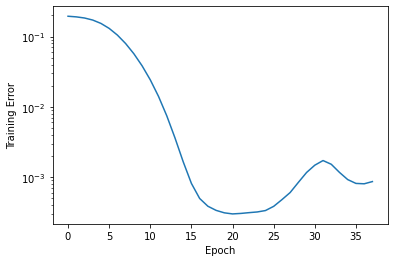

In [15]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.show()

Cargamos los valores de los pesos del mejor resultado de entrenamiento.

In [16]:
model.load_weights("matrix_factorization_weights.hdf5")

Evaluamos el modelo con datos del conjunto de *test*.

In [17]:
results = model.evaluate((test.display_id, test.ad_id), test.clicked, batch_size = 1)

2000/2000 [==============================] - 3s 1ms/step - loss: 0.2121 - mae: 0.2478 - mse: 0.2121


In [18]:
ad_embedding_learnt = model.get_layer(name='ad-Embedding').get_weights()[0]

In [19]:
display_embedding_learnt = model.get_layer(name='display-Embedding').get_weights()[0]

In [20]:
def recommend(display_id, number_of_ads = 5): #Obtiene la lista de recomendaciones codificada 
    ads = display_embedding_learnt[display_id]@ad_embedding_learnt.T
    mids = np.argpartition(ads, -number_of_ads)[-number_of_ads:]
    return mids

In [21]:
def get_list(list_rec): #Obtiene los valores originales
    lista=[]
    for item in list_rec:
        lista.append(list(dataset[dataset['ad_id']==item]['ad_id_original'])[0])
    return lista

Obtenemos 5 *display_id* al azar para realizar predicciones.

In [22]:
display_ids = list(dataset.sample(5)['display_id'] + 1)
print(display_ids)

[1157, 290, 88, 251, 654]


In [23]:
for display_id in display_ids:
    list_recommend = get_list(recommend(display_id = display_id))
    lista_a = list_recommend
    print(f"Para el display_id: {display_id} se recomiendan los siguientes ads_id: {list_recommend}")
    ad_ids = list(dataset[dataset["display_id"] == display_id]['ad_id'])
    lista_b = ad_ids
    print(f"El display_id: {display_id} tenía los siguientes ads_id: {ad_ids}")
    print(set(lista_a).intersection(lista_b))
    print('-'*50)

Para el display_id: 1157 se recomiendan los siguientes ads_id: [56751, 202812, 103641, 333874, 159665]
El display_id: 1157 tenía los siguientes ads_id: [322, 395, 1390, 1674]
set()
--------------------------------------------------
Para el display_id: 290 se recomiendan los siguientes ads_id: [288068, 8991, 93324, 128496, 228795]
El display_id: 290 tenía los siguientes ads_id: [257, 2055, 3376, 4225]
set()
--------------------------------------------------
Para el display_id: 88 se recomiendan los siguientes ads_id: [215666, 92759, 332908, 149541, 136785]
El display_id: 88 tenía los siguientes ads_id: [870, 2684, 3107, 3229]
set()
--------------------------------------------------
Para el display_id: 251 se recomiendan los siguientes ads_id: [91681, 332908, 265795, 202812, 51063]
El display_id: 251 tenía los siguientes ads_id: [626, 1058, 1141, 2048]
set()
--------------------------------------------------
Para el display_id: 654 se recomiendan los siguientes ads_id: [80483, 121894, 55

Un display_id es un campo que individualiza a un usuario en un contexto determinado (display_id, uuid, document_id, timestamp, platform, geo_location)

## Factorización de Máquinas

Cargamos los tres archivos más relevantes, porque del cruce de ellos podemos obtener un DataFrame que contenga el *uuid*, el *document_id*, el *display_id* y el *ad_id*.

In [24]:
df_page_views = pd.read_csv('../data/page_views_sample.csv')
df_events = pd.read_csv('../data/events.csv')
df_clicks_train = pd.read_csv('../data/clicks_train.csv')

tmp1 = pd.merge(df_page_views, df_events, on = ['uuid', 'document_id', 'timestamp', 'platform', 'geo_location'], how = 'inner')
tmp1 = pd.merge(tmp1, df_clicks_train, on = 'display_id', how = 'inner')

/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_82231/761515679.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv('../data/events.csv')


In [25]:
print(f'{len(tmp1)} registros.')
print('-'*20)
tmp1.head()

303277 registros.
--------------------


,uuid,document_id,timestamp,platform,geo_location,traffic_source,display_id,ad_id,clicked
0,f785c2aa914e62,4491,82544941,3,AU>07,1,1382805,162129,0
1,f785c2aa914e62,4491,82544941,3,AU>07,1,1382805,177268,1
2,f785c2aa914e62,4491,82544941,3,AU>07,1,1382805,184717,0
3,c7867cc2f27c43,13205,57402673,2,US>VA>511,2,910882,14089,0
4,c7867cc2f27c43,13205,57402673,2,US>VA>511,2,910882,83251,0


Luego, hacemos el cruce de toda la información relevante del contenido y sus documentos.

In [26]:
df_promoted_content = pd.read_csv('../data/promoted_content.csv')
df_documents_categories = pd.read_csv('../data/documents_categories.csv')
df_documents_entities = pd.read_csv('../data/documents_entities.csv')
df_documents_topics = pd.read_csv('../data/documents_topics.csv')
df_documents_meta = pd.read_csv('../data/documents_meta.csv')

tmp2 = pd.merge(df_promoted_content, df_documents_categories, on = 'document_id', how = 'inner')
tmp2 = pd.merge(tmp2, df_documents_entities, on = 'document_id', how = 'inner')
tmp2 = pd.merge(tmp2, df_documents_topics, on = 'document_id', how = 'inner')

In [27]:
print(f'{len(tmp2)} registros.')
print('-'*20)
tmp2.head()

14388861 registros.
--------------------


,ad_id,document_id,campaign_id,advertiser_id,category_id,confidence_level_x,entity_id,confidence_level_y,topic_id,confidence_level
0,5,471472,2,7,1608,0.92,ab221a25404b918c465dbc7ded6e3d58,0.703974,143,0.089059
1,5,471472,2,7,1608,0.92,ab221a25404b918c465dbc7ded6e3d58,0.703974,26,0.065245
2,5,471472,2,7,1608,0.92,ab221a25404b918c465dbc7ded6e3d58,0.703974,294,0.050676
3,5,471472,2,7,1608,0.92,ab221a25404b918c465dbc7ded6e3d58,0.703974,221,0.043812
4,5,471472,2,7,1608,0.92,ab221a25404b918c465dbc7ded6e3d58,0.703974,20,0.033216


Creamos un DataFrame final que cruce los dos DataFrames antes mencionados.

In [28]:
df_fm = pd.merge(tmp1, tmp2, on = 'document_id', how = 'inner')
print(f'{len(df_fm)} registros.')
print('-'*20)
df_fm.head()

1366230 registros.
--------------------


,uuid,document_id,timestamp,platform,geo_location,traffic_source,display_id,ad_id_x,clicked,ad_id_y,campaign_id,advertiser_id,category_id,confidence_level_x,entity_id,confidence_level_y,topic_id,confidence_level
0,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,86d10d76fb6219bf88720c83604a15b3,0.356491,269,0.249975
1,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,b736f69d7a475d2d29685fe3310e85e0,0.256732,269,0.249975
2,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,18dbc63a3e6b6576d206afa849b4c57f,0.252150,269,0.249975
3,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1706,0.061117,86d10d76fb6219bf88720c83604a15b3,0.356491,269,0.249975
4,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1706,0.061117,b736f69d7a475d2d29685fe3310e85e0,0.256732,269,0.249975


Definimos las columnas de interés, tanto las categóricas como la columna objetivo que en este caso es *clicked*.

In [29]:
class Config:
    category_col = ['uuid', 
                    'document_id', 
                    'timestamp', 
                    'platform', 
                    'geo_location', 
                    'traffic_source', 
                    'display_id',  
                    'ad_id_x', 
                    'ad_id_y', 
                    'campaign_id', 
                    'advertiser_id', 
                    'category_id', 
                    'confidence_level_x', 
                    'entity_id', 
                    'confidence_level_y', 
                    'topic_id', 
                    'confidence_level']
    num_col = []
    target_col = ['clicked']
    
    epochs=5
    batch_size=128
    seed=17
    embedding_dim=8
    lr=1e-4
    
config=Config()

In [30]:
def build_preprocessor(config): 
    category_col = config.category_col
    num_col = config.num_col
    
    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std', (StandardScaler())),])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value='NAN')),
        ('oe', (OrdinalEncoder())),
        ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_col),
            ('cat', categorical_transformer, category_col),
        ],
        remainder="drop")
    return preprocessor
    
def preprocess(df, config):
    
    category_col = config.category_col
    num_col = config.num_col
    target_col = config.target_col
    
    print(df.shape)
    doc_id_cnt = df.groupby('document_id').size()
    use_docs = list(doc_id_cnt[doc_id_cnt > 10].index)
    df = df[df['document_id'].isin(use_docs)]
    print(df.shape)

    df[target_col] = df[target_col].astype(int)

    pp = build_preprocessor(config)
    pp.fit(df)
    return df, pp

Preprocesamos la información para asegurar que el DataFrame no tenga datos nulos.

In [31]:
df, pp = preprocess(df_fm, config)

(1366230, 18)
(1366230, 18)


In [32]:
df.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source,display_id,ad_id_x,clicked,ad_id_y,campaign_id,advertiser_id,category_id,confidence_level_x,entity_id,confidence_level_y,topic_id,confidence_level
0,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,86d10d76fb6219bf88720c83604a15b3,0.356491,269,0.249975
1,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,b736f69d7a475d2d29685fe3310e85e0,0.256732,269,0.249975
2,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,18dbc63a3e6b6576d206afa849b4c57f,0.252150,269,0.249975
3,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1706,0.061117,86d10d76fb6219bf88720c83604a15b3,0.356491,269,0.249975
4,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1706,0.061117,b736f69d7a475d2d29685fe3310e85e0,0.256732,269,0.249975


In [33]:
pp.transform(df).shape

(1366230, 17)

In [34]:
df.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source,display_id,ad_id_x,clicked,ad_id_y,campaign_id,advertiser_id,category_id,confidence_level_x,entity_id,confidence_level_y,topic_id,confidence_level
0,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,86d10d76fb6219bf88720c83604a15b3,0.356491,269,0.249975
1,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,b736f69d7a475d2d29685fe3310e85e0,0.256732,269,0.249975
2,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1406,0.803258,18dbc63a3e6b6576d206afa849b4c57f,0.252150,269,0.249975
3,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1706,0.061117,86d10d76fb6219bf88720c83604a15b3,0.356491,269,0.249975
4,b3bd6de5dfc3dc,347446,66320213,2,CA>ON,1,1097542,188570,0,87402,2827,1485,1706,0.061117,b736f69d7a475d2d29685fe3310e85e0,0.256732,269,0.249975


Dividimos el DataFrame en los conjuntos de entrenamiento y validación para ajustar el modelo.

In [35]:
tra_df, val_df = train_test_split(df, test_size=0.2, stratify=df['display_id'], random_state=config.seed)
print(tra_df.shape)
print(val_df.shape)

(1092984, 18)
(273246, 18)


Construimos el modelo, asignando una por cada *feature*.

In [36]:
def build_model(category_num, category_cols, num_cols, K=8, solver='adam', l2=0.0, l2_fm=0.0):

    # Numerical features
    num_inputs = [Input(shape=(1,), name=col,) for col in num_cols]
    # Categorical features
    cat_inputs = [Input(shape=(1,), name=col,) for col in category_cols]

    inputs = num_inputs + cat_inputs

    flatten_layers=[]
    # Numerical featrue embedding
    for enc_inp, col in zip(num_inputs, num_cols):
        # num featrue dence
        x = Dense(K, name = f'embed_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_layers.append(x)

    # Category feature embedding
    for enc_inp, col in zip(cat_inputs, category_cols):
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=K,
                            input_length=1,
                            name=f'embed_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        flatten_layers.append(flatten_c)
                
    # Feature interaction term
    fm_layers = []
    for emb1,emb2 in itertools.combinations(flatten_layers, 2):
        dot_layer = dot([emb1,emb2], axes=1)
        fm_layers.append(dot_layer)
        
    # Linear term
    for enc_inp,col in zip(cat_inputs, category_cols):
        # embedding
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=1,
                            input_length=1,
                            name=f'linear_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        fm_layers.append(flatten_c)
                
    for enc_inp, col in zip(num_inputs, num_cols):
        x = Dense(1, name = f'linear_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        fm_layers.append(x)

    # Add all terms
    flatten = add(fm_layers)
    outputs = Activation('sigmoid',name='outputs')(flatten)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
                optimizer=solver,
                loss='binary_crossentropy',
                metrics='accuracy'
              )

    return model 

Obtenemos el modelo y obtenemos un resumen que indica que tiene 148.833 parámetros, todos ellos entrenables.

In [37]:
category_num = {col: df[col].nunique() for col in config.category_col}
model = build_model(category_num, config.category_col, config.num_col)

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 uuid (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 document_id (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 timestamp (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 platform (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

Al igual que en el modelo anterior, definimos dos callbacks para asegurarnos tener el mejor resultado.

In [39]:
early = [EarlyStopping(monitor='val_loss', min_delta = 1e-4, patience = 2, verbose = 0,)]
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = "factorization_machine_weights.hdf5",
                                   verbose = 1,
                                   monitor = "loss",
                                   save_best_only = True)
cbs = [early, checkpoint]

feature_num = len(config.category_col + config.num_col)
tra_inputs = [pp.transform(tra_df)[:, i] for i in range(feature_num)]
val_inputs = [pp.transform(val_df)[:, i] for i in range(feature_num)]

In [40]:
tra_df

,uuid,document_id,timestamp,platform,geo_location,traffic_source,display_id,ad_id_x,clicked,ad_id_y,campaign_id,advertiser_id,category_id,confidence_level_x,entity_id,confidence_level_y,topic_id,confidence_level
1299366,3b50225152a646,927056,3842645,3,US>IL>602,1,49469,308610,0,45817,2320,1448,1403,0.654445,d635b56f85e7f1b234429539ed88df2a,0.230541,26,0.059502
1346335,6afe92a9fd2984,1798564,85206713,2,US>CT>501,2,1427412,236502,1,354091,255,15,1912,0.920000,b15f6ea4f7917df3ef17e0bf2e463263,0.248447,199,0.115542
464290,7e1eb671978c41,804322,38601283,1,US>AR>734,1,499317,104748,0,125368,16063,3001,2003,0.070000,fd247d924ab8158154fbba46b75aee14,0.974280,2,0.108948
193536,a5f4909efcd595,1552983,6954757,2,US>CA>803,1,81490,64255,0,306090,28587,3972,1809,0.920000,9db0a2f3ed67b8b731fc3419b2fcc523,0.935224,20,0.038452
267913,6287ec87182ed3,1767529,39136843,1,US>WI>705,1,510016,94305,0,331405,16904,201,1708,0.920000,4aafb4afc42b4609a147ef2ac578d8e1,0.283262,241,0.013313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600960,bca6c344a1c6f4,804322,67654211,2,US>PA>508,1,1121939,125326,0,125377,16062,3001,1302,0.920000,fd247d924ab8158154fbba46b75aee14,0.974280,2,0.108948
928144,5bfe3d60c10e88,1629915,56422563,1,US>IL>602,1,888647,135958,1,423781,28790,1635,1903,0.681611,8b5d7de070e0c11161a62aebd567913b,0.303015,199,0.215301
1059470,9600028795c0df,1649400,1000456,1,GB>X4,1,14346,247108,0,285812,25885,112,1403,0.070000,66f405f009888775ffeb5ceee409fc23,0.365416,8,0.119923
732995,3bbe3d14cba0e1,1747935,42960970,1,GB>H9,3,588633,208431,0,323836,25885,112,1408,0.920000,fcf1c12158d072d1b3977f2f0e398f82,0.266763,192,0.027211


Entrenamos el modelo.

In [41]:
history = model.fit(
          x=tra_inputs,
          y=tra_df[config.target_col],
          epochs=config.epochs,
          batch_size=config.batch_size,
          validation_data=(val_inputs,
                           val_df[config.target_col]),
          callbacks = cbs
         )

Epoch 1/5
8534/8539 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9652
Epoch 1: loss improved from inf to 0.10139, saving model to factorization_machine_weights.hdf5
8539/8539 [==============================] - 64s 6ms/step - loss: 0.1014 - accuracy: 0.9652 - val_loss: 0.0165 - val_accuracy: 0.9957
Epoch 2/5
8533/8539 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9977
Epoch 2: loss improved from 0.10139 to 0.00835, saving model to factorization_machine_weights.hdf5
8539/8539 [==============================] - 51s 6ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 0.9982
Epoch 3/5
8538/8539 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9989
Epoch 3: loss improved from 0.00835 to 0.00319, saving model to factorization_machine_weights.hdf5
8539/8539 [==============================] - 51s 6ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 4/5
8531

Graficamos los resultados obtenidos en las variables de *accuracy* y *loss*.

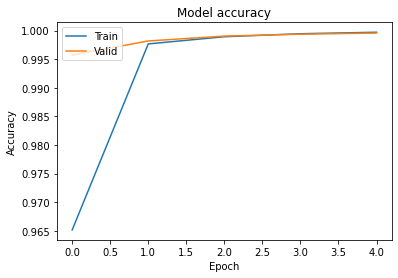

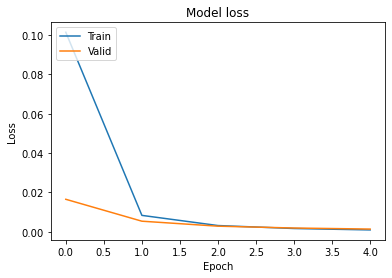

In [42]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()    
plot_history(history)

Cargamos en el modelo los pesos del mejor resultado obtenido en entrenamiento.

In [43]:
model.load_weights("factorization_machine_weights.hdf5")

Observamos las características del conjunto de validación para con él hacer predicciones.

In [44]:
val_df.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source,display_id,ad_id_x,clicked,ad_id_y,campaign_id,advertiser_id,category_id,confidence_level_x,entity_id,confidence_level_y,topic_id,confidence_level
198185,3e59add36230b6,1552983,25907145,2,US>TX>641,1,254969,123742,0,306090,28587,3972,1808,0.070000,9db0a2f3ed67b8b731fc3419b2fcc523,0.935224,23,0.009898
803750,1fc230177e8622,438834,40878992,1,US>GA>524,1,545374,258569,0,36309,2831,1486,1303,0.070000,739a25879fb8e50acdbd71350a33a178,0.497671,299,0.226637
786121,10b764c60b0b12,438834,41940130,1,US>AR>693,1,567014,154424,0,36309,2831,1486,1303,0.070000,848d94a2da8d170fc2dc9474433f5690,0.230940,147,0.013300
426319,6875e5ad5a4832,804322,71927272,1,CA>NL,1,1196932,151882,1,125370,16063,3001,1302,0.920000,fd247d924ab8158154fbba46b75aee14,0.974280,84,0.134100
333908,2106c29f637c61,1497549,48308928,1,US>CA>825,1,706582,92434,1,427301,24517,1634,1408,0.045247,5112934d89974c78e1ad3c27963c597e,0.245696,221,0.012056


In [45]:
val_df['document_id'].value_counts()

804322     72100
1649400    58092
1552983    47827
1629915    26538
438834     13716
           ...  
1791385        4
373625         4
641409         3
1794241        3
989368         2
Name: document_id, Length: 141, dtype: int64

Tomamos 5 *document_id* al azar para realizar predicciones. Podemos notar que la predicción se ajusta al valor presente en la columna *clicked*.

In [47]:
# 5 documents_id de muestra
documents_ids = list(val_df.sample(5)['document_id']) 

for document_id in documents_ids:
    print(f"document_id: {document_id}")
    user = document_id
    user_df = val_df.reset_index(drop = True).query('document_id==@user')
    user_inputs = [pp.transform(val_df)[user_df.index, i] for i in range(feature_num)]
    user_df['pred'] = model.predict(user_inputs)
    user_df = user_df.sort_values('pred', ascending=False)
    print(user_df[['uuid', 'display_id', 'ad_id_x', 'ad_id_y', 'clicked', 'pred']])
    print('-'*50)

document_id: 1649400
1816/1816 [==============================] - 7s 3ms/step
                  uuid  display_id  ad_id_x  ad_id_y  clicked          pred
265144  1f779606fc2425      127139   158220   273567        1  1.000000e+00
64371   24afe835f122cc      254789   137758   270167        1  1.000000e+00
214583  27b7725b1e502d      692323   137758   270167        1  1.000000e+00
232873  2b108d3ff61352       46701   127051   270167        1  1.000000e+00
64767   a15ffd623c877a       69971    39675   270167        1  1.000000e+00
...                ...         ...      ...      ...      ...           ...
272991  340537d7ab4a96       81382   155250   285812        0  5.145982e-26
126190  340537d7ab4a96       81382   155250   285812        0  4.849292e-26
227267  340537d7ab4a96       81382   155250   273567        0  4.831308e-26
146894  340537d7ab4a96       81382   155250   273567        0  4.826003e-26
78425   340537d7ab4a96       81382   155250   285812        0  4.423828e-26

[58092 ro